##### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from  imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

##### The dataset

In [2]:
path= r'C:\Users\HP\Desktop\backorder project\notebook\data\backorder_data.csv'  # Use the path of your downloaded dataset for avoiding errors
data= pd.read_csv(path)
data.head()

,Unnamed: 0,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [3]:
train_data = None
test_data = None
          
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_shuffle_split.split(data, data['went_on_backorder'].fillna(data['went_on_backorder'].mode()[0])):
    train_data = data.loc[train_index].drop(columns=['Unnamed: 0'])
    test_data = data.loc[test_index].drop(columns=['Unnamed: 0'])

##### Data Preprocessing

In [4]:
train_data= train_data.dropna()
train_data= train_data.drop(columns=['sku'])

cat_features = train_data.select_dtypes(include=['object'])
num_features = train_data.select_dtypes(include=np.number)

for col in cat_features:
    cat_features[col].replace('No',0,inplace=True)
    cat_features[col].replace('Yes',1,inplace=True)

train_data= pd.concat([num_features,cat_features],axis=1)

In [5]:
X= train_data.drop(['went_on_backorder','forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)
y= train_data['went_on_backorder']

scaler= StandardScaler()

skf= StratifiedKFold(random_state=42,shuffle=True)

##### Model Training

In [6]:
model_performance= pd.DataFrame(columns=['Model Name','AUC_ROC_Score','AUC_PR_Score'])

##### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
log_model= LogisticRegression(random_state=42)

roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    log_model.fit(X_train_scaled,y_train)
    y_pred= log_model.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[0]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')


Roc_score: 0.62931485845858
PR_score: 0.012855811894019614


##### Logistic Regression with Smote

In [8]:
log_model_sm= LogisticRegression(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    X_train_scaled = scaler.fit_transform(X_train_sm)
    X_val_scaled = scaler.transform(X_val)

    log_model_sm.fit(X_train_scaled,y_train_sm)
    y_pred= log_model_sm.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[1]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.729026901429587
PR_score: 0.02683736257119615


##### Logistic Regression with RandomOverSampling

In [9]:
log_model_ovr= LogisticRegression(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    X_train_scaled = scaler.fit_transform(X_train_ovr)
    X_val_scaled = scaler.transform(X_val)

    log_model_ovr.fit(X_train_scaled,y_train_ovr)
    y_pred= log_model_ovr.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[2]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.76431945826052
PR_score: 0.02843452135309098


##### Logistic Regression with RandomUnderSampling

In [10]:
log_model_und= LogisticRegression(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_und)
    X_val_scaled = scaler.transform(X_val)

    log_model_und.fit(X_train_scaled,y_train_und)
    y_pred= log_model_und.predict_proba(X_val_scaled)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'Logistic with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[3]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.759907501742001
PR_score: 0.02717700832874385


##### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt_model= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    dt_model.fit(X_train,y_train)
    y_pred= dt_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[4]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.6671877491955648
PR_score: 0.2128192895061424


##### Decision Tree with Smote

In [12]:
dt_model_sm= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    dt_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= dt_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[5]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.6857619095444052
PR_score: 0.22212577965063157


##### Decision Tree with RandomOverSampling

In [13]:
dt_model_ovr= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    dt_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= dt_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[6]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.6507116701807879
PR_score: 0.1977804196745693


##### Decision Tree with RandomUnderSampling

In [14]:
dt_model_und= DecisionTreeClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    dt_model_und.fit(X_train_und,y_train_und)
    y_pred= dt_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'CART with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[7]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8449659126200666
PR_score: 0.4364699065530765


##### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    rf_model.fit(X_train,y_train)
    y_pred= rf_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[8]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8979474672873037
PR_score: 0.31941310640186876


##### Random Forest with Smote

In [16]:
rf_model_sm = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    rf_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= rf_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[9]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9087326801025629
PR_score: 0.18646140247906381


##### Random Forest with RandomOverSampling

In [17]:
rf_model_ovr = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    rf_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= rf_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[10]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8896403019685094
PR_score: 0.16197897426603144


##### Random Forest with RandomUnderSampling

In [18]:
rf_model_und = RandomForestClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    rf_model_und.fit(X_train_und,y_train_und)
    y_pred= rf_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'RF with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[11]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9440252124856825
PR_score: 0.1797965086332574


##### Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    gb_model.fit(X_train,y_train)
    y_pred= gb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[12]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9266079926292787
PR_score: 0.1819623839037415


##### Gradient Boosting with Smote

In [20]:
gb_model_sm = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    gb_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= gb_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[13]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9275932110534629
PR_score: 0.1427906920109846


##### Gradient Boosting with RandomOverSampling

In [21]:
gb_model_ovr = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    gb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= gb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[14]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9362698326598895
PR_score: 0.16688673659769648


##### Gradient Boosting with RandomUnderSampling

In [22]:
gb_model_und = GradientBoostingClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    gb_model_und.fit(X_train_und,y_train_und)
    y_pred= gb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'GBoost with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[15]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.935608106632808
PR_score: 0.16366831763817258


##### XGBoost

In [23]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    xgb_model.fit(X_train,y_train)
    y_pred= xgb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[16]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9453196915368338
PR_score: 0.243626354636394


##### XGBoost with Smote

In [24]:
xgb_model_sm = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    xgb_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= xgb_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost with Smote','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[17]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9260907435357895
PR_score: 0.13839514611677095


##### XGBoost with RandomOverSampling

In [25]:
xgb_model_ovr = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_over = RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr = ran_over.fit_resample(X_train, y_train)

    xgb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= xgb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost with RandomOverSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[18]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9426986478343894
PR_score: 0.21828352189825012


##### XGBoost with RandomUnderSampling

In [26]:
xgb_model_und = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    xgb_model_und.fit(X_train_und,y_train_und)
    y_pred= xgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

new_row= {'Model Name': 'XGBoost with RandomUnderSampling','AUC_ROC_Score': sum(roc_score)/len(roc_score),'AUC_PR_Score':sum(pr_score)/len(pr_score) }
model_performance.loc[19]= new_row
print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9427529027224514
PR_score: 0.16009727417020708


##### Training Scores of different models

In [27]:
model_performance

,Model Name,AUC_ROC_Score,AUC_PR_Score
0,Logistic,0.629315,0.012856
1,Logistic with Smote,0.729027,0.026837
2,Logistic with RandomOverSampling,0.764319,0.028435
3,Logistic with RandomUnderSampling,0.759908,0.027177
4,CART,0.667188,0.212819
5,CART with Smote,0.685762,0.222126
6,CART with RandomOverSampling,0.650712,0.197780
7,CART with RandomUnderSampling,0.844966,0.436470
8,RF,0.897947,0.319413
9,RF with Smote,0.908733,0.186461


##### Model Testing

##### Data Preprocessing

In [28]:
test_data= test_data.dropna()
test_data= test_data.drop(columns=['sku'])

cat_features = test_data.select_dtypes(include=['object'])
num_features = test_data.select_dtypes(include=np.number)

for col in cat_features:
    cat_features[col].replace('No',0,inplace=True)
    cat_features[col].replace('Yes',1,inplace=True)

test_data= pd.concat([num_features,cat_features],axis=1)

X_test= test_data.drop(['went_on_backorder','forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)
y_test= test_data['went_on_backorder']

scaler = StandardScaler()

In [29]:
def evaluate_estimators(estimators, X_test, y_test):
    roc_scores = []
    pr_scores = []

    X_scale= scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    for estimator in estimators:
        if estimator in [log_model,log_model_sm,log_model_ovr,log_model_und]:
            y_pred = estimator.predict_proba(X_test_scaled)[:, 1]
        else:
            y_pred = estimator.predict_proba(X_test)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        auc_pr = auc(recall, precision)
        pr_scores.append(auc_pr)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_roc = auc(fpr, tpr)
        roc_scores.append(auc_roc)

    test_scores = pd.DataFrame({
        'AUC_ROC_test':roc_scores,
        'AUC_PR_test':pr_scores
    })
    return test_scores


In [30]:
test_scores= evaluate_estimators([log_model,log_model_sm,log_model_ovr,log_model_und,
                     dt_model,dt_model_sm,dt_model_ovr,dt_model_und,
                     rf_model,rf_model_sm,rf_model_ovr,rf_model_und,
                     gb_model,gb_model_sm,gb_model_ovr,gb_model_und,
                     xgb_model,xgb_model_sm,xgb_model_ovr,xgb_model_und],X_test,y_test)

##### Models performance comparison on train and test data

In [31]:
model_performance= pd.concat([model_performance,test_scores],axis=1)
model_performance

,Model Name,AUC_ROC_Score,AUC_PR_Score,AUC_ROC_test,AUC_PR_test
0,Logistic,0.629315,0.012856,0.616128,0.012212
1,Logistic with Smote,0.729027,0.026837,0.717237,0.024347
2,Logistic with RandomOverSampling,0.764319,0.028435,0.754291,0.027221
3,Logistic with RandomUnderSampling,0.759908,0.027177,0.688799,0.016391
4,CART,0.667188,0.212819,0.663687,0.211346
5,CART with Smote,0.685762,0.222126,0.675097,0.211655
6,CART with RandomOverSampling,0.650712,0.197780,0.651693,0.204703
7,CART with RandomUnderSampling,0.844966,0.436470,0.844797,0.435738
8,RF,0.897947,0.319413,0.900397,0.305471
9,RF with Smote,0.908733,0.186461,0.908659,0.173053


<Axes: >

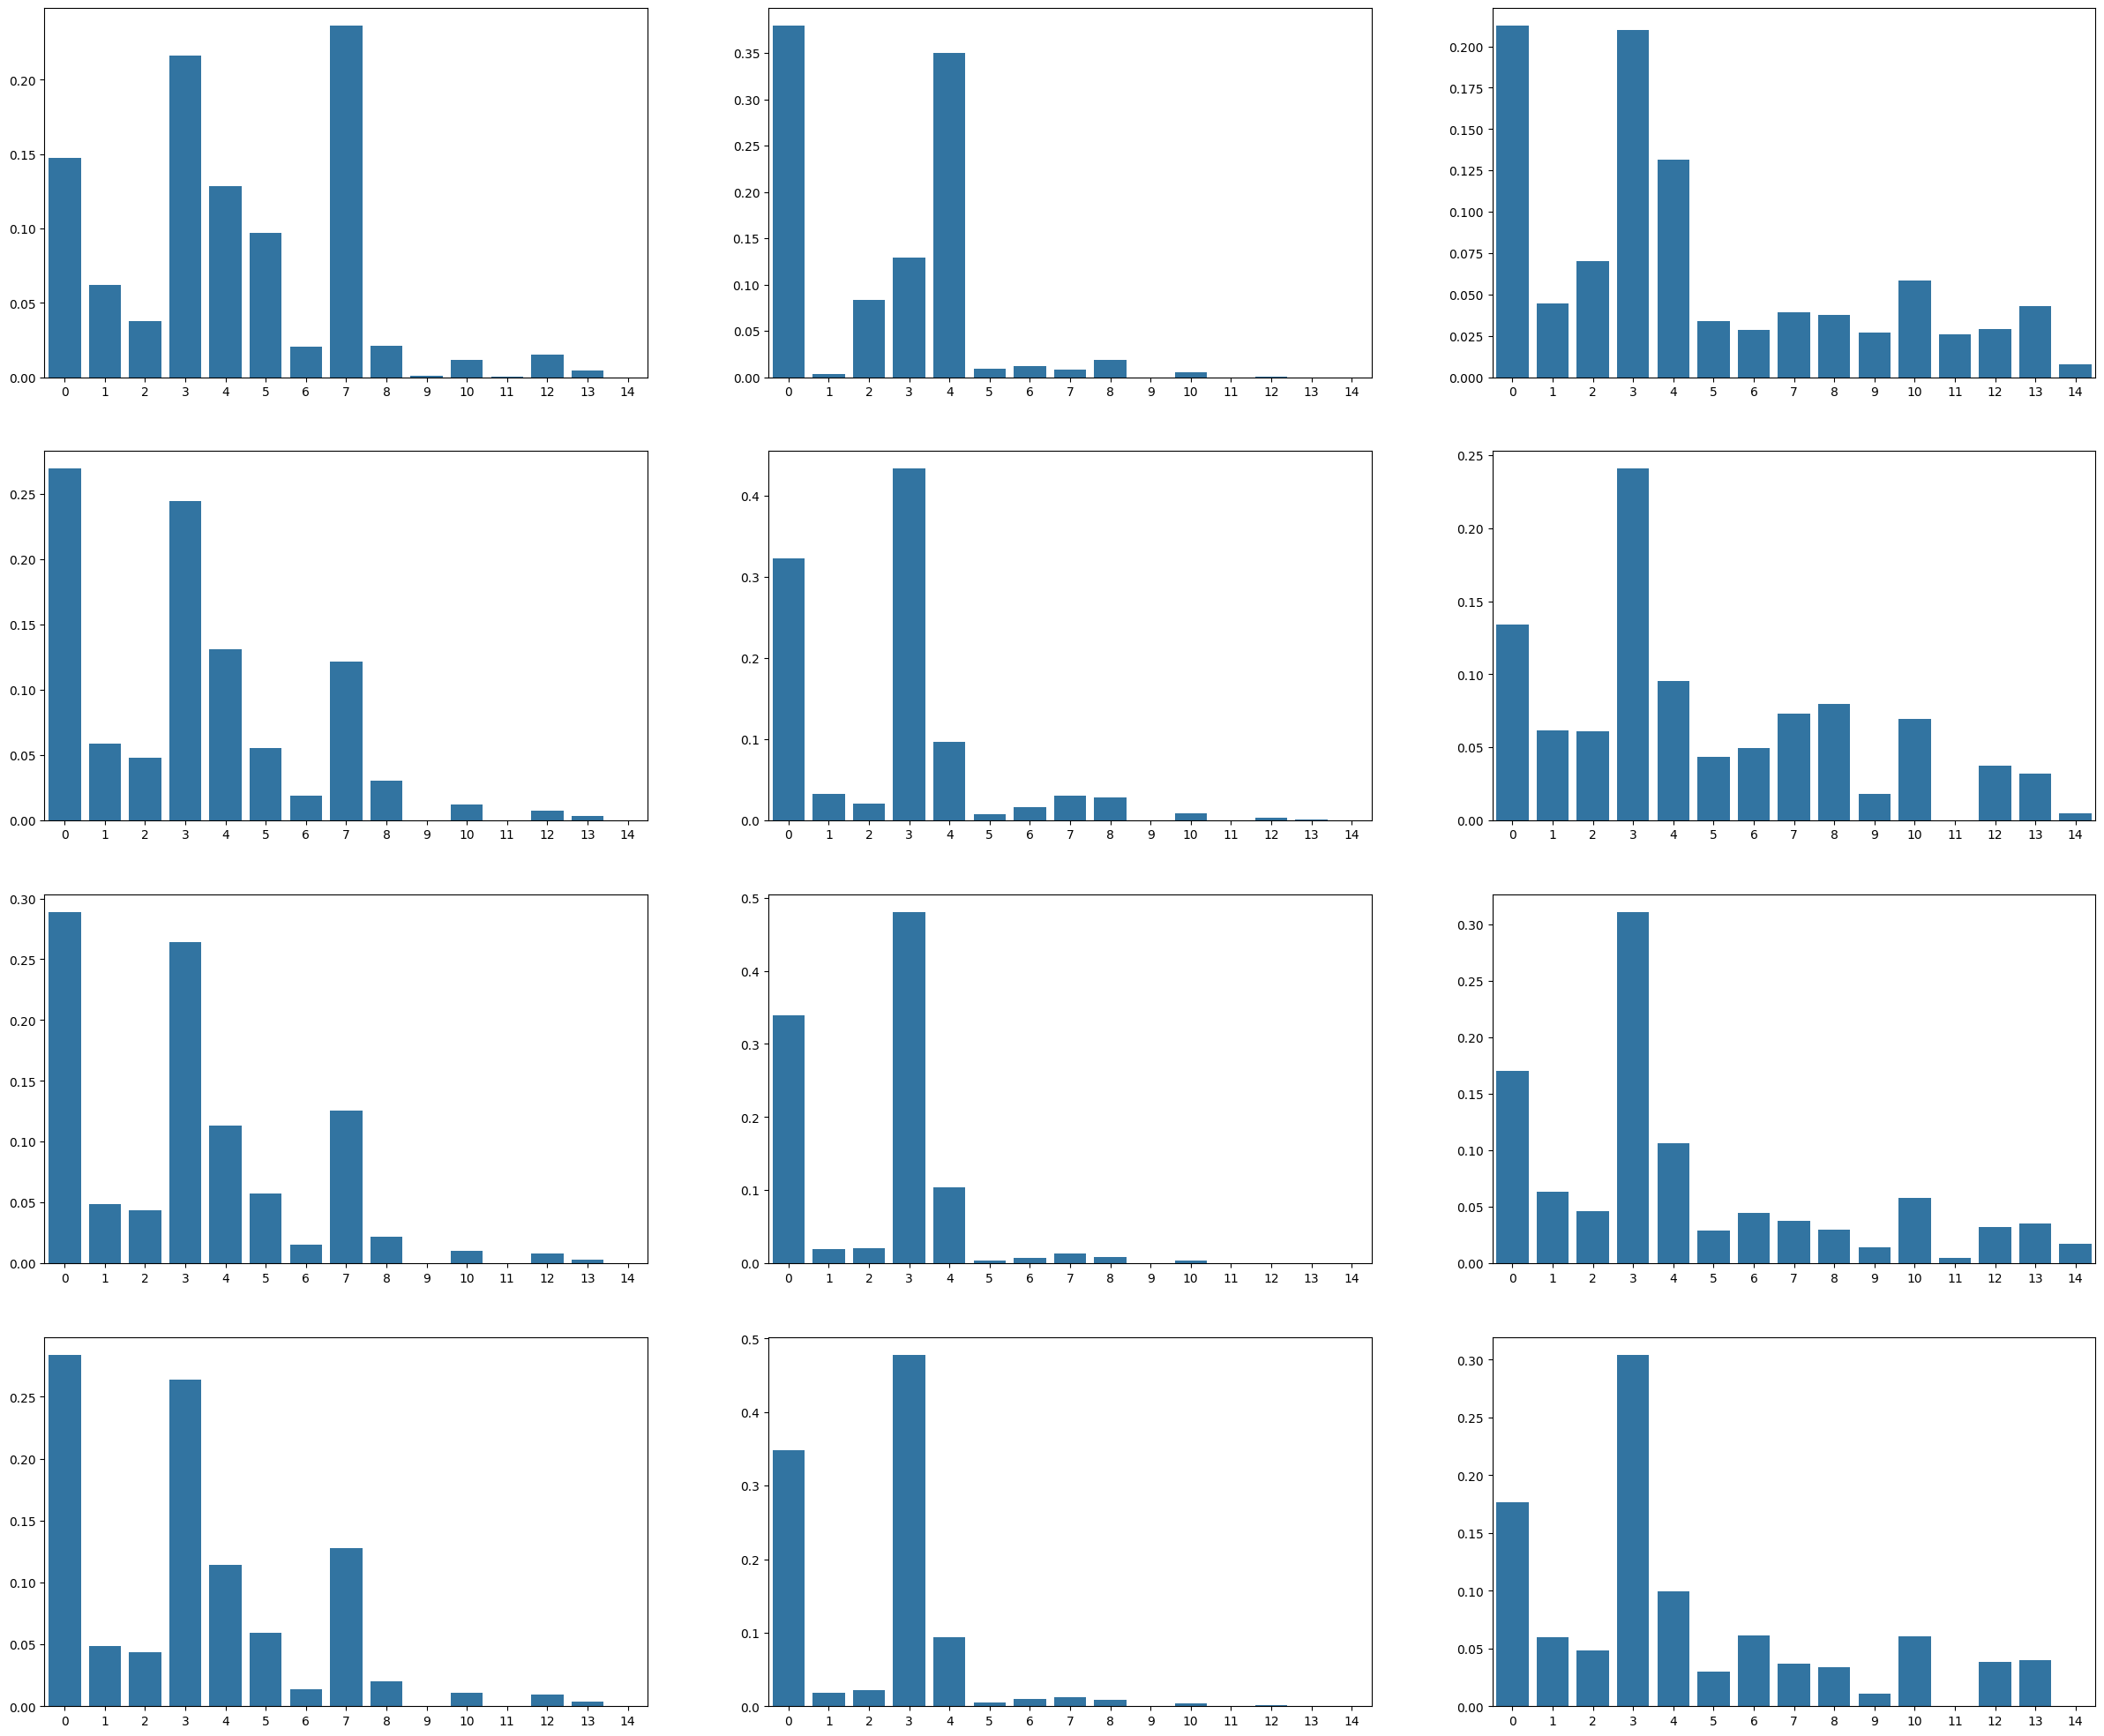

In [32]:
rf_importances= rf_model.feature_importances_
gb_importances= gb_model.feature_importances_
xgb_importances= xgb_model.feature_importances_
rf_importances_ovr = rf_model_ovr.feature_importances_
gb_importances_ovr = gb_model_ovr.feature_importances_
xgb_importances_ovr = xgb_model_ovr.feature_importances_
rf_importances_sme = rf_model_sm.feature_importances_
gb_importances_sme = gb_model_sm.feature_importances_
xgb_importances_sme= xgb_model_sm.feature_importances_
rf_importances_und = rf_model_und.feature_importances_
gb_importances_und = gb_model_und.feature_importances_
xgb_importances_und= xgb_model_und.feature_importances_

fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(30,25))
plt.subplot(4,3,1)
sns.barplot(rf_importances)
plt.subplot(4,3,2)
sns.barplot(gb_importances)
plt.subplot(4,3,3)
sns.barplot(xgb_importances)
plt.subplot(4,3,4)
sns.barplot(rf_importances_sme)
plt.subplot(4,3,5)
sns.barplot(gb_importances_sme)
plt.subplot(4,3,6)
sns.barplot(xgb_importances_sme)
plt.subplot(4,3,7)
sns.barplot(rf_importances_ovr)
plt.subplot(4,3,8)
sns.barplot(gb_importances_ovr)
plt.subplot(4,3,9)
sns.barplot(xgb_importances_ovr)
plt.subplot(4,3,10)
sns.barplot(rf_importances_und)
plt.subplot(4,3,11)
sns.barplot(gb_importances_und)
plt.subplot(4,3,12)
sns.barplot(xgb_importances_und)